In [1]:
# To handle Pytorch training issues in Apple MAC M1 Pro chip
%env PYTORCH_ENABLE_MPS_FALLBACK=1
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
# !pip install -Uqq fastai

# imports

In [3]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *

In [4]:
# from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *

# Gathering data

In [5]:
def search_images(term, max_images=3):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images('batman', max_images=3)
print (f"# of urls: {len(urls)}")
urls[0]

Searching for 'batman'


/Users/prasanth.thangavel/.pyenv/versions/3.10.5/envs/fastai_related/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/Users/prasanth.thangavel/.pyenv/versions/3.10.5/envs/fastai_related/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/Users/prasanth.thangavel/.pyenv/versions/3.10.5/envs/fastai_related/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


# of urls: 3


'https://images3.alphacoders.com/107/1072867.jpg'

In [7]:
ims = ['https://imagesvc.timeincapp.com/v3/fan/image?&c=sc&w=1920&h=2500&url=https://bamsmackpow.com/wp-content/blogs.dir/308/files/2016/04/Batman4.jpg']

In [10]:
dest = 'images/batman.jpg'
download_url(ims[0], dest)

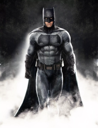

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

## Image types

In [30]:
hero_types = 'batman','superman','flash'
path = Path('superheroes')

In [32]:
if not path.exists():
    path.mkdir()
    for o in hero_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images(f'{o}', max_images=150)
        download_images(dest, urls=results)

In [33]:
fns = get_image_files(path)
fns

(#234) [Path('superheroes/superman/73c004ef-947a-46c9-8194-69419e4f7606.jpg'),Path('superheroes/superman/cecf6396-4a16-457f-9fe7-81c707d40e72.png'),Path('superheroes/superman/c02efb54-8576-4102-9826-23c46e7003a0.jpg'),Path('superheroes/superman/5d7613aa-abcd-42f6-952a-4f51482aeba3.jpg'),Path('superheroes/superman/4fbde748-29b2-4ee9-9828-cd892f1b36fd.png'),Path('superheroes/superman/d76295f7-2136-453c-88b2-ec75c7d26dbd.png'),Path('superheroes/superman/3acc87e3-3f8b-4ce4-a23a-5ff234fd8467.jpg'),Path('superheroes/superman/4326f31e-58f7-41d9-bbff-3738305b2af5.png'),Path('superheroes/superman/db175927-708a-45dc-8717-2edb08d1d01f.jpg'),Path('superheroes/superman/6206a946-c08b-4753-8633-3e6d415a2803.jpg')...]

In [34]:
failed = verify_images(fns)
failed

(#0) []

In [35]:
failed.map(Path.unlink);

In [68]:
print(f"Total images used for training and validation: {len(dls.items)}")

Total images used for training and validation: 188


# Data to DataLoaders

In [36]:
heroes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [37]:
dls = heroes.dataloaders(path)

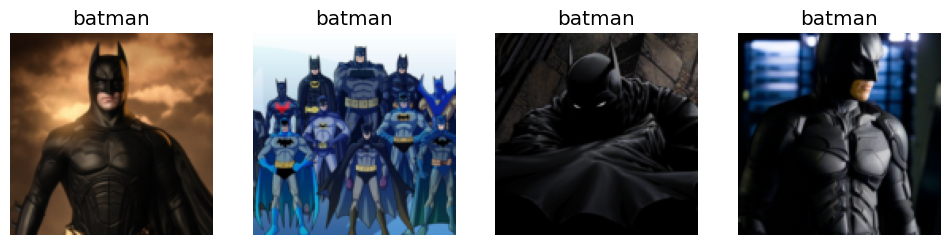

In [38]:
dls.valid.show_batch(max_n=4, nrows=1)

# Training our model, and using it to clean our data

In [39]:
heroes = heroes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = heroes.dataloaders(path)

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

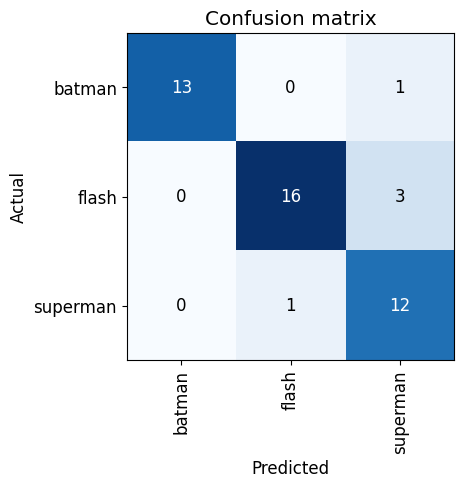

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

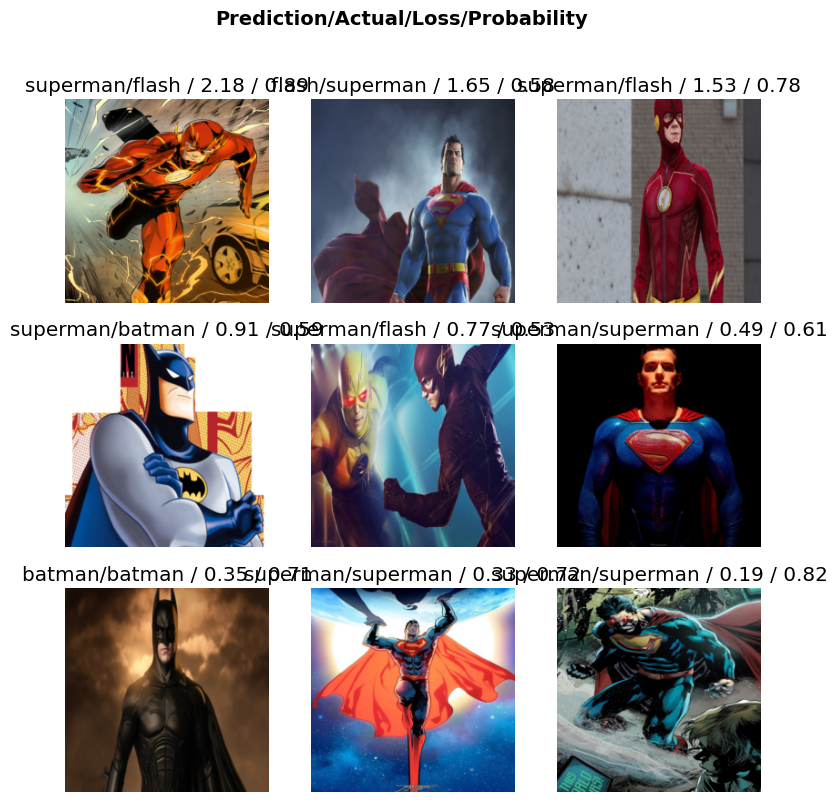

In [43]:
interp.plot_top_losses(9, nrows=3)

In [44]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

> note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

# Turning Your Model into an Online Application

In [45]:
learn.export('who_is_the_hero_model.pkl')

# Load the exported model

In [47]:
learn_inf = load_learner("who_is_the_hero_model.pkl")

# Load a static image

im.shape: (192, 148)


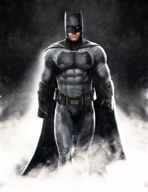

In [54]:
im = PILImage.create('images/batman.jpg')
im.thumbnail((192,192))
print(f"im.shape: {im.shape}")
im

# Perform predictions

In [55]:
# Probabilities: [P(Dog), P(Cat)]
%time learn_inf.predict(im)

CPU times: user 51.5 ms, sys: 55.3 ms, total: 107 ms
Wall time: 61.9 ms


('batman', tensor(0), tensor([0.9405, 0.0028, 0.0566]))

In [56]:
learn_inf.dls.vocab

['batman', 'flash', 'superman']

In [57]:
categories = learn_inf.dls.vocab

def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [58]:
classify_image(im)

{'batman': 0.9405215978622437,
 'flash': 0.002849522978067398,
 'superman': 0.056628864258527756}